In [16]:
import numpy as np
import math
import matplotlib.pyplot as plt
import jax
import pennylane as qml
from jax import numpy as jnp
import optax
from scipy.integrate import trapezoid

# np.set_printoptions(precision=15)  # For consistent display precision

import warnings
warnings.filterwarnings("ignore")

### Activation functions

In [17]:
## ReLU activation function
def relu(x_array):
    x = x_array
    y = np.full(len(x),np.nan,dtype=np.float64)
    j = np.mean(x)
    for i in range(len(x)):
        if x[i] < j or x[i] == j:       # ReLU(x) = max(0,x-5)
            y[i] = (0)
        else:
            y[i] = x[i]-j
            
    y = [y[i] + 2 for i in range(len(x))]
    
    area = trapezoid(y,x)
    normalized_y = y/area
    
    return normalized_y


#Sigmoid activation function
def modified_sigmoid(x):
    """Compute the modified sigmoid function that is zero at x=5."""
    return 1 / (1 + np.exp(-(x))) 

def sigmoid(x_array):
    x = x_array
    y = np.full(len(x),np.nan,dtype=np.float64)
    j = np.mean(x)
    for i in range(len(x)):
        y[i] = modified_sigmoid(x[i]-j)
        
    y = y + 5
    area = trapezoid(y,x)
    normalized_y = y/area
    
    return normalized_y


# Elu activation function
def modified_elu(x):
    return 1*(np.exp(x)-1)

def elu(x_array):
    x = x_array
    y = np.full(len(x),np.nan,dtype=np.float64)
    j = np.mean(x)
    for i in range(len(x)):
        if x[i]>j:
            y[i] = x[i]-j
        else:
            y[i] = modified_elu(x[i]-j)
    
    y = [y[i] + 5 for i in range(len(x))]
    
    area = trapezoid(y,x)
    normalized_y = y/area
    
    return normalized_y


#Tanh activation function
def tanh(x_array):
    x = x_array
    y = np.full(len(x),np.nan,dtype=np.float64)
    j = np.mean(x_array)
    for i in range(len(x)):
        y[i] = np.tanh(x[i]-j)
    y = [y[i] + 2 for i in range(len(x))]
    area = trapezoid(y,x)
    normalized_y = y/area
    return normalized_y

### Target Distribution

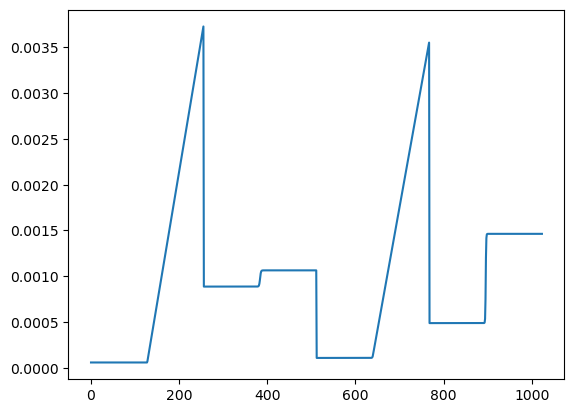

In [18]:
n_qubits = 10
x_full = np.arange(0,2**n_qubits,dtype=np.float64)

x_split = np.array_split(x_full,4)

y1 = relu(x_split[0])
y2 = sigmoid(x_split[1] - x_split[1][0])
y3 = elu(x_split[2] - x_split[2][0])
y4 = tanh(x_split[3] - x_split[3][0])

target_distribution = np.concatenate([y1,y2,y3,y4])
target_distribution /= trapezoid(target_distribution)
plt.plot(x_full,target_distribution)


### Particle Number Distribution

In [19]:
def pnumber_distribution(distribution):
    p_distribution = np.zeros(n_qubits+1,dtype=np.float64)
    
    for i in range(2**n_qubits):
        binary_string = format(i,'06b')
        num_of_ones = binary_string.count('1')
        p_distribution[num_of_ones] += distribution[i]
        
    #Normalize the distribution
    p_distribution/=p_distribution.sum()
    return p_distribution

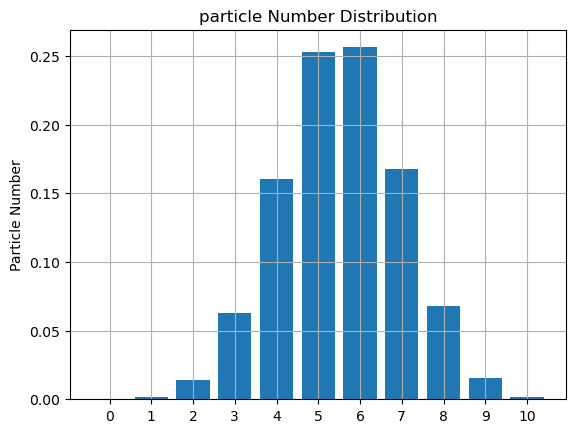

In [20]:
targetp_distribution = pnumber_distribution(target_distribution)
plt.bar(range(n_qubits+1), targetp_distribution)
plt.title('particle Number Distribution')
plt.ylabel('Particle Number')
plt.xticks(range(n_qubits+1))
plt.grid(True)
plt.show()

### QCBM Circuit

In [21]:
from scipy.special import comb

n_ancillas = 2
total_qubits = n_qubits + n_ancillas
dev = qml.device('default.qubit',wires=total_qubits)

def uniform_init(num_qubits,distribution=targetp_distribution):
    all_states = [format(i, f'0{num_qubits}b') for i in range(2**num_qubits)]
        
    ## Random selection of particle number states    
    # all_state_dict = {i:0 for i in all_states}

    # a=np.random.choice(['0001','0010','0100','1000'],1)[0]
    # b=np.random.choice(['0011','0101','1001','0110','1100','1010'],1)[0]
    # c=np.random.choice(['0111','1011','1101','1110'],1)[0]
    
    # chosen_states = ['0000','0001','0011','0111','1111']
    # chosen_state_dict = dict(zip(chosen_states,np.sqrt(distribution)))
    
    amps = []
    
    #uniform distribution of all possible states
    for i in all_states:
        num_of_ones = i.count('1')
        number_of_states_with_num_of_ones = comb(num_qubits, num_of_ones)
        amps.append(distribution[num_of_ones] / number_of_states_with_num_of_ones)
        
    amps = np.sqrt(amps)        
    # all_state_dict.update(chosen_state_dict)
    
    
    #amplitudes
    # amps = list(all_state_dict.values())
    # norm = np.sqrt(sum(np.abs(amp)**2 for amp in amps))
    # amps = amps/norm
    
    #print(amps)
    qml.StatePrep(amps,wires=range(num_qubits))
    
    
def qcbm_circuit(params,total_qubits):
    
    rz_params = params[:total_qubits]
    ising_params = params[total_qubits:]
    
    for i in range(total_qubits):
        # qml.RX(ising_params[i],wires=i)
        qml.RZ(rz_params[i],wires=i)

    # for i in range(total_qubits-1):
    #     qml.CNOT(wires=[i,i+1])
    # qml.CNOT(wires=[total_qubits-1,0])
    
    
    for i in range(total_qubits-1):
        qml.IsingXY(ising_params[i],wires=[i,i+1])
    qml.IsingXY(ising_params[total_qubits-1],wires=[total_qubits-1,0])
    
    for i in range(total_qubits-1):
        qml.IsingZZ(ising_params[i],wires=[i,i+1])
    qml.IsingZZ(ising_params[total_qubits-1],wires=[total_qubits-1,0])
    
    

@qml.qnode(dev, interface='jax')
def circuit(input_params,distribution=targetp_distribution,num_qubits=n_qubits,ancilla_qubits=n_ancillas,total_qubits=total_qubits):

    #Random state for pretraining
    uniform_init(num_qubits,distribution)
    
    #Layers of Rotation + Entangling gates
    
    for i in range(10):
        qml.Barrier(range(total_qubits))
        qcbm_circuit(params=input_params[i],total_qubits=total_qubits)
    
    # ancilla_check = qml.probs(wires=[9,10])
    # # if not np.all(ancilla_check == 0):
    #     # raise ValueError("Ancilla qubits are not all in the |0> state!")
    #     # print(ancilla_check)
    
    return qml.probs(wires=[0,1,2,3,4,5,6,7,8,9])
    # return [qml.probs(wires=[0,1,2,3,4,5,6,7]),qml.probs(wires=[8]),qml.probs(wires=[9])]


### Loss Function

In [22]:
class MMD:
    def __init__(self,scales,space):
        gammas = 1/(2*(scales**2)).reshape(-1,1,1)
        sq_dists = np.abs(space[:,None] - space[None,:])**2
        self.K = np.sum(np.exp(-gammas * sq_dists), axis=0)/len(scales)
        self.scales = scales
        
    def k_expval(self,px,py):
        return px @ self.K @ py
    
    def __call__(self,px,py):
        # print(np.size(px),np.size(py))
        pxy = px-py
        return self.k_expval(pxy,pxy)
    
class QCBM:
    def __init__(self,circ,mmd,py):
        self.circ = circ
        self.mmd = mmd
        self.py = py
    
    def mmd_loss(self,params):
        px = self.circ(params)
        # print(np.size(px))
        return self.mmd(px,self.py), px

In [23]:
folds = 10
initial_params = []
for i in range(folds):
    #Each layer has 3*9=18 params i.e., 9 Rotation + (9+9) Ising Entangling
    initial_params.append(np.random.rand(3*total_qubits).tolist())

### Training the model

In [24]:

def update_step(params,opt_state):
    
    (loss_val,qcbm_probs), grads = jax.value_and_grad(qcbm.mmd_loss,has_aux=True)(params)

    updates,opt_state = opt.update(grads,opt_state)
    params = optax.apply_updates(params,updates)
    
    qcbm_probs = np.asarray(qcbm_probs, dtype=np.float64)
    
    kl_div = -np.sum(target_distribution * np.nan_to_num(np.log(qcbm_probs) - np.log(target_distribution)))
    
    return params, opt_state, loss_val, kl_div

In [25]:
# def update_step(params, opt_state):
#     # Compute the loss and auxiliary outputs
#     loss_val, qcbm_probs = qcbm.mmd_loss(params)
    
#     # Compute the gradients
#     jacobian = jax.jacobian(qcbm.mmd_loss)(params)
#     grads = jnp.sum(jacobian, axis=1)
    
#     # Update the parameters using the optimizer
#     updates, opt_state = opt.update(grads, opt_state)
#     params = optax.apply_updates(params, updates)
    
#     qcbm_probs = np.asarray(qcbm_probs, dtype=np.float64)
    
#     # Compute the KL divergence
#     kl_div = -np.sum(target_distribution * np.nan_to_num(np.log(qcbm_probs) - np.log(target_distribution)))
    
#     return params, opt_state, loss_val, kl_div

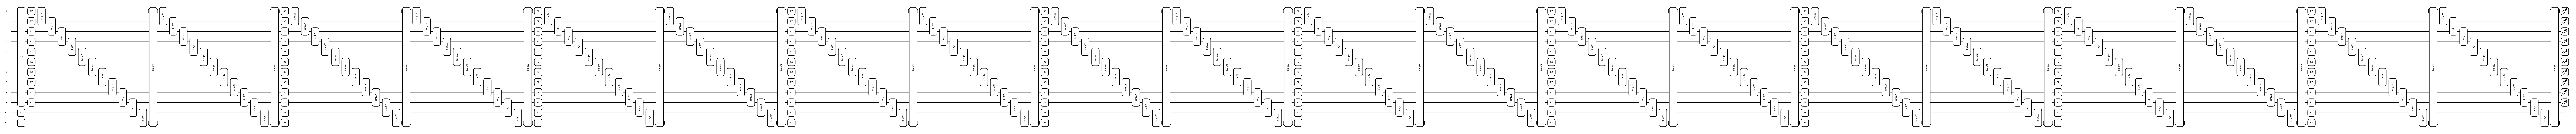

In [26]:
qml.draw_mpl(circuit,level='device')(input_params=initial_params)
plt.show()

In [27]:
#Calling MMD class
bandwidth = np.array([0.25,60],dtype=np.float64)
space = np.arange(0,2**n_qubits,dtype=np.float64)
mmd = MMD(bandwidth,space=space)

#Calling QCBM class to run the previous built circuit with random weights
qcbm = QCBM(circuit,mmd=mmd,py=target_distribution)

#Initial parameters
weights = initial_params


#Call an optimizer
lr = optax.exponential_decay(init_value=0.1,transition_steps=10,decay_rate=0.9,transition_begin=300,staircase=True)
# lr = 1e-1
opt = optax.adam(learning_rate=lr)
opt_state = opt.init(weights)

history = []
divs = []
parameters = []
# n_iterations = 400

kl_div = 1
i = 0
while kl_div > 10^-3:
    i+=1
    current_lr = lr(i)
    weights, opt_state, loss_val, kl_div = update_step(params=weights,opt_state=opt_state)
    
    if i%10==0:
        print(f"Step: {i} Loss: {loss_val} KL_div:{kl_div} current_lr:{current_lr}")
    
    history.append(loss_val)
    divs.append(kl_div)
    parameters.append(weights)

Step: 10 Loss: 0.004045477136969566 KL_div:0.6071200434562961 current_lr:0.10000000149011612
Step: 20 Loss: 0.0010846024379134178 KL_div:0.4429191170080643 current_lr:0.10000000149011612
Step: 30 Loss: 0.0005686566000804305 KL_div:0.2996684527787705 current_lr:0.10000000149011612
Step: 40 Loss: 0.00043027300853282213 KL_div:0.2323966274378239 current_lr:0.10000000149011612
Step: 50 Loss: 0.0002881057152990252 KL_div:0.19458514822768827 current_lr:0.10000000149011612
Step: 60 Loss: 0.00024166582443285733 KL_div:0.17086785018968342 current_lr:0.10000000149011612
Step: 70 Loss: 0.00018741295207291842 KL_div:0.15310423296109857 current_lr:0.10000000149011612
Step: 80 Loss: 0.0002791146107483655 KL_div:0.14340272194533876 current_lr:0.10000000149011612
Step: 90 Loss: 0.00017519679386168718 KL_div:0.13565072410397788 current_lr:0.10000000149011612
Step: 100 Loss: 0.00013966918049845845 KL_div:0.1281398910585007 current_lr:0.10000000149011612
Step: 110 Loss: 0.0001467900729039684 KL_div:0.119

KeyboardInterrupt: 

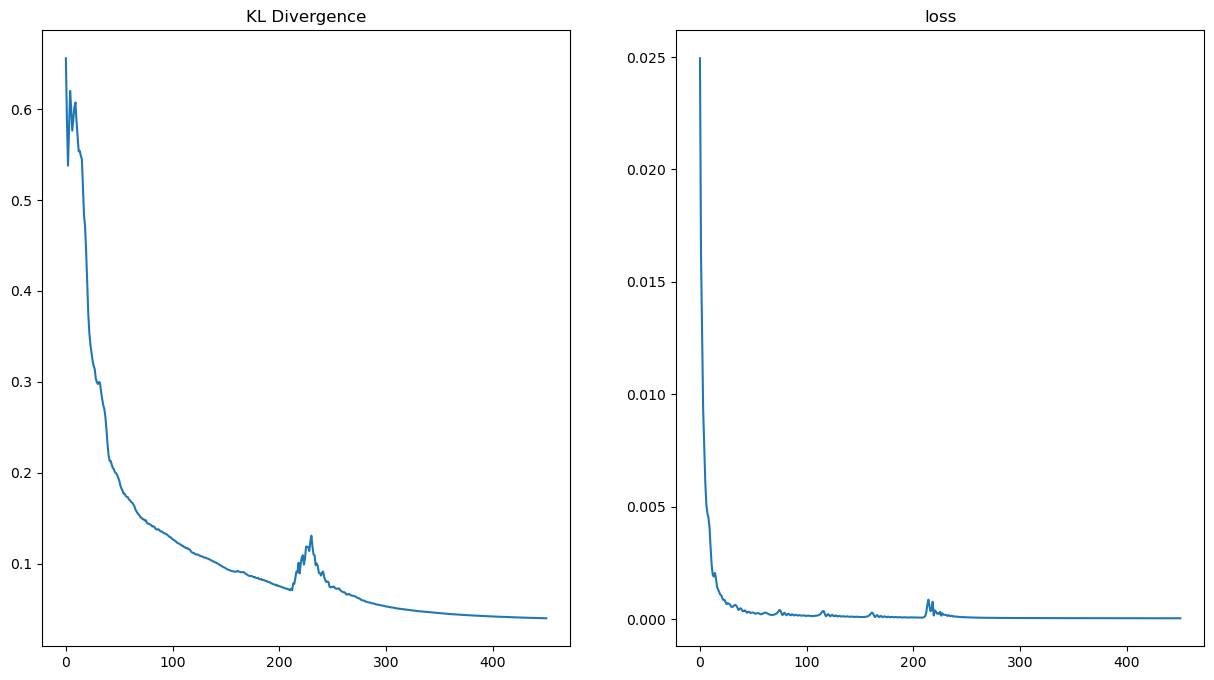

In [28]:
fig, axs = plt.subplots(1,2,figsize=(15,8))
axs[0].plot(divs)
axs[0].title.set_text('KL Divergence')

axs[1].plot(history)
axs[1].title.set_text('loss')

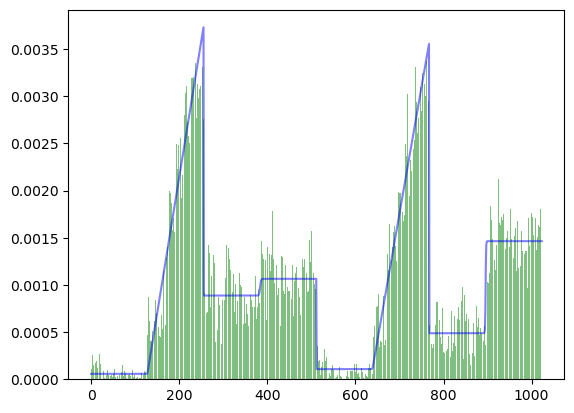

In [29]:
optimal_params = parameters[np.argmin(divs)]
qcbm_probs = circuit(optimal_params)
plt.bar(x_full,qcbm_probs,color='green',alpha=0.5,label='obtained_distribution')
plt.plot(x_full,target_distribution,color='blue',alpha=0.5,label='target_distribution')

In [30]:
print(f"The minimum KL divergence obtained : {np.min(divs)}")

The minimum KL divergence obtained : 0.0402376122794675
